In [1]:
%matplotlib notebook

import os
import time
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td 
import torchvision as tv
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt 
import nntools as nt
import styleDataSet
from itertools import chain
from DnCNN import DnCNN

import my_image as myi
import styleDataSet as sd
import ganNet as gn

In [11]:
def plot(exp, fig, axes, content, style, visu_rate=2): 
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        transfered = exp.trainer.gen2s(content[np.newaxis].to(exp.trainer.gen2s.device))[0] 
    axes[0][0].clear()
    axes[0][1].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    myi.myimshow(content, ax=axes[0][0]) 
    axes[0][0].set_title('Content image') 
    
    myi.myimshow(style, ax=axes[0][1]) 
    axes[0][1].set_title('Style image')

    myi.myimshow(transfered, ax=axes[1][0]) 
    axes[1][0].set_title('Transfered image')
    
    axes[1][1].plot([exp.history[k][1].item() 
                     for k in range(exp.epoch)],label="Gen Loss")
    axes[1][1].plot([exp.history[k][2].item()
                     for k in range(exp.epoch)],label="Dis Loss")
    
    axes[1][1].legend(loc='best')
    
    axes[1][1].set_xlabel("Epoch")
    axes[1][1].set_ylabel("Loss")
    
    plt.tight_layout() 
    fig.canvas.draw()
    

def multi_final_result( use_train, *test_ids):
    assert (use_train is True or use_train is False), "first input must be True or False" 
    img_num = len(test_ids)
    fig, axes = plt.subplots(ncols=4, nrows=img_num, figsize=(7,6)) 
    
    for i in range(img_num):
        if use_train:
            to_test = train_set[i][np.newaxis].to(device)
        else:
            to_test = test_set[i][np.newaxis].to(device)
            
        myi.myimshow(to_test[0], axes[i][0])
        myi.myimshow(style_ref, axes[i][1])
        
        with torch.no_grad():
            myi.myimshow(cycleGAN_exp.trainer.gen2s(to_test)[0] , ax=axes[i][2])
            myi.myimshow(cycleEXP_long.trainer.gen2s(to_test)[0] , ax=axes[i][3])

        axes[i][0].set_title("content")
        axes[i][1].set_title("style")
        axes[i][2].set_title("100 epo")
        axes[i][3].set_title("200 epo")
    fig.tight_layout()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cuda


In [4]:
content_root_dir = "//datasets/ee285f-public/flickr_landscape/"
style_root_dir = "/datasets/ee285f-public/wikiart/wikiart/"
train_set = sd.StyleTransDataset(content_root_dir, style_root_dir, "city", "Art_Nouveau_Modern")
test_set = sd.StyleTransDataset(content_root_dir, style_root_dir, "mountain", "Art_Nouveau_Modern")

In [5]:
transform = tv.transforms.Compose([
            tv.transforms.Resize((150, 150)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])

style_ref = Image.open("./starry_night.jpg").convert('RGB')
style_ref = transform(style_ref)

# use for plot and see effect
content_ref = Image.open("./house.jpg").convert('RGB')
content_ref = transform(content_ref)

In [6]:
gen2s = gn.Generator(6).to(device)
gen2c = gn.Generator(6).to(device)
dis_c = gn.Discriminator(6).to(device)
dis_s = gn.Discriminator(6).to(device)

cycleGan_trainer = gn.CGANTrainer(gen2s, gen2c, dis_c, dis_s, device)

In [7]:
cycleGAN_exp = gn.CGANexp(cycleGan_trainer, train_set, output_dir="cycleGAN_ckpt", batch_size = 4, picNum = 20,
                     perform_validation_during_training=True)

cycleEXP_long = gn.CGANexp(cycleGan_trainer, train_set, output_dir="cycleGAN_ckpt_long",
                        batch_size = 2, picNum = 500, perform_validation_during_training=True)

Done Load from Checkpoint!
Done Load from Checkpoint!


<IPython.core.display.Javascript object>


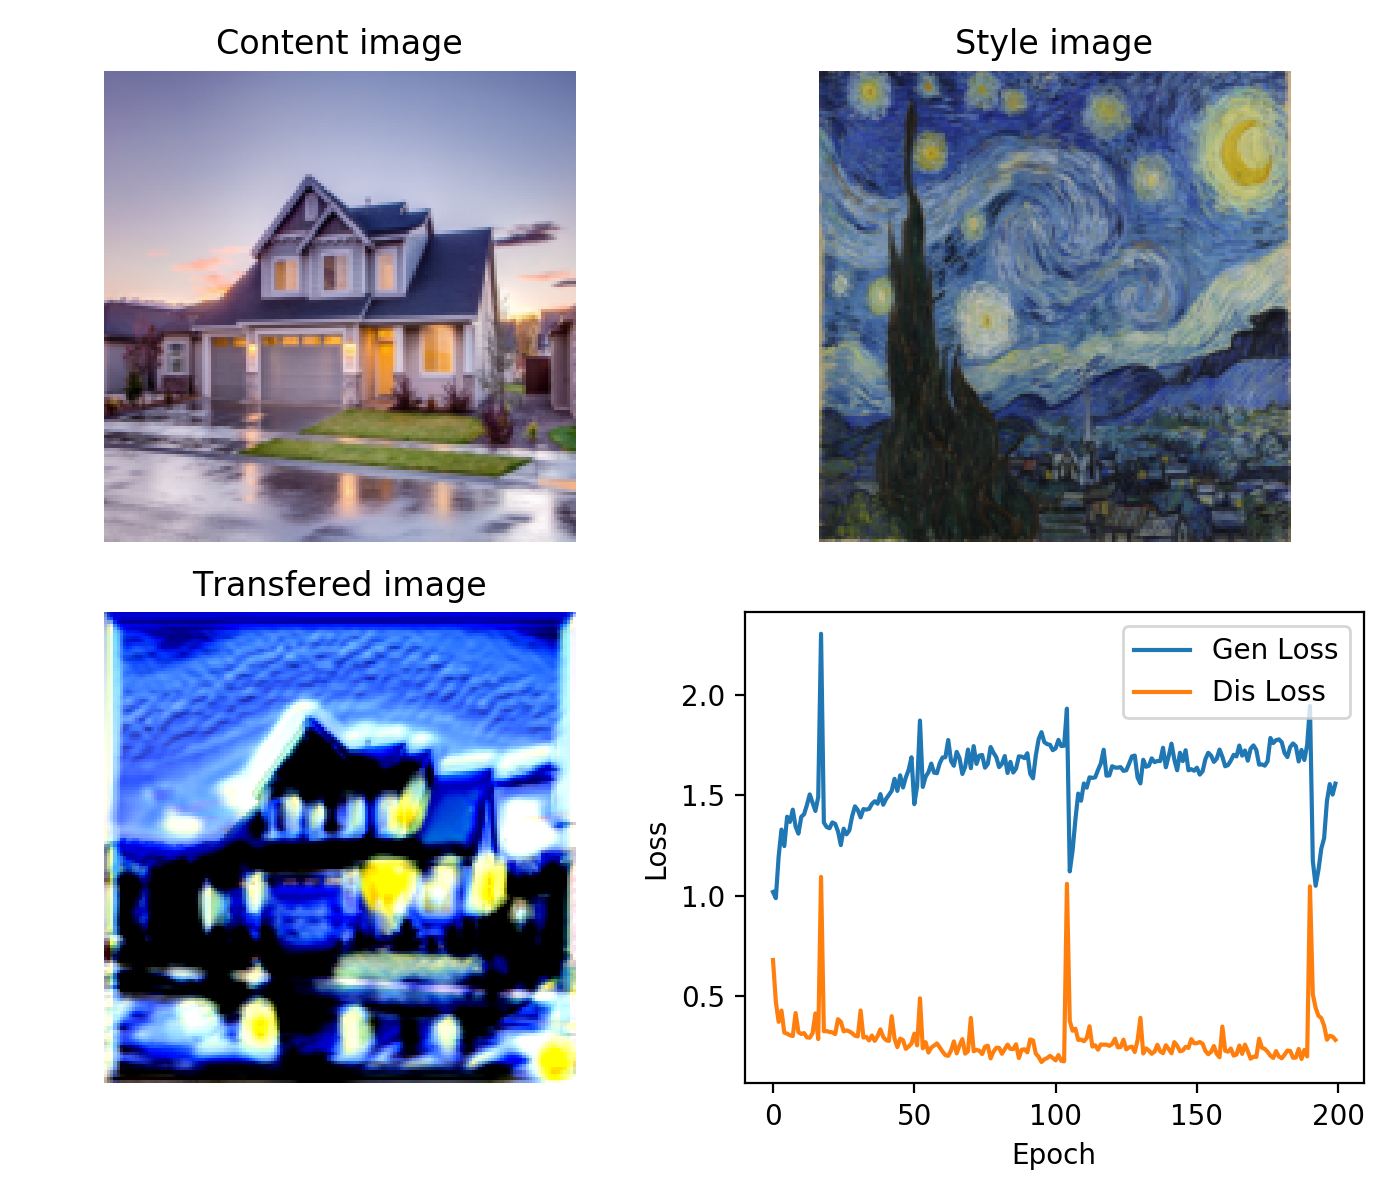

Start/Continue training from epoch 200


In [14]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,6)) 
cycleEXP_long.run(num_epochs=200, plot=lambda exp: plot(exp, fig=fig, axes=axes, 
                                                content=content_ref,
                                                style=style_ref))

<IPython.core.display.Javascript object>


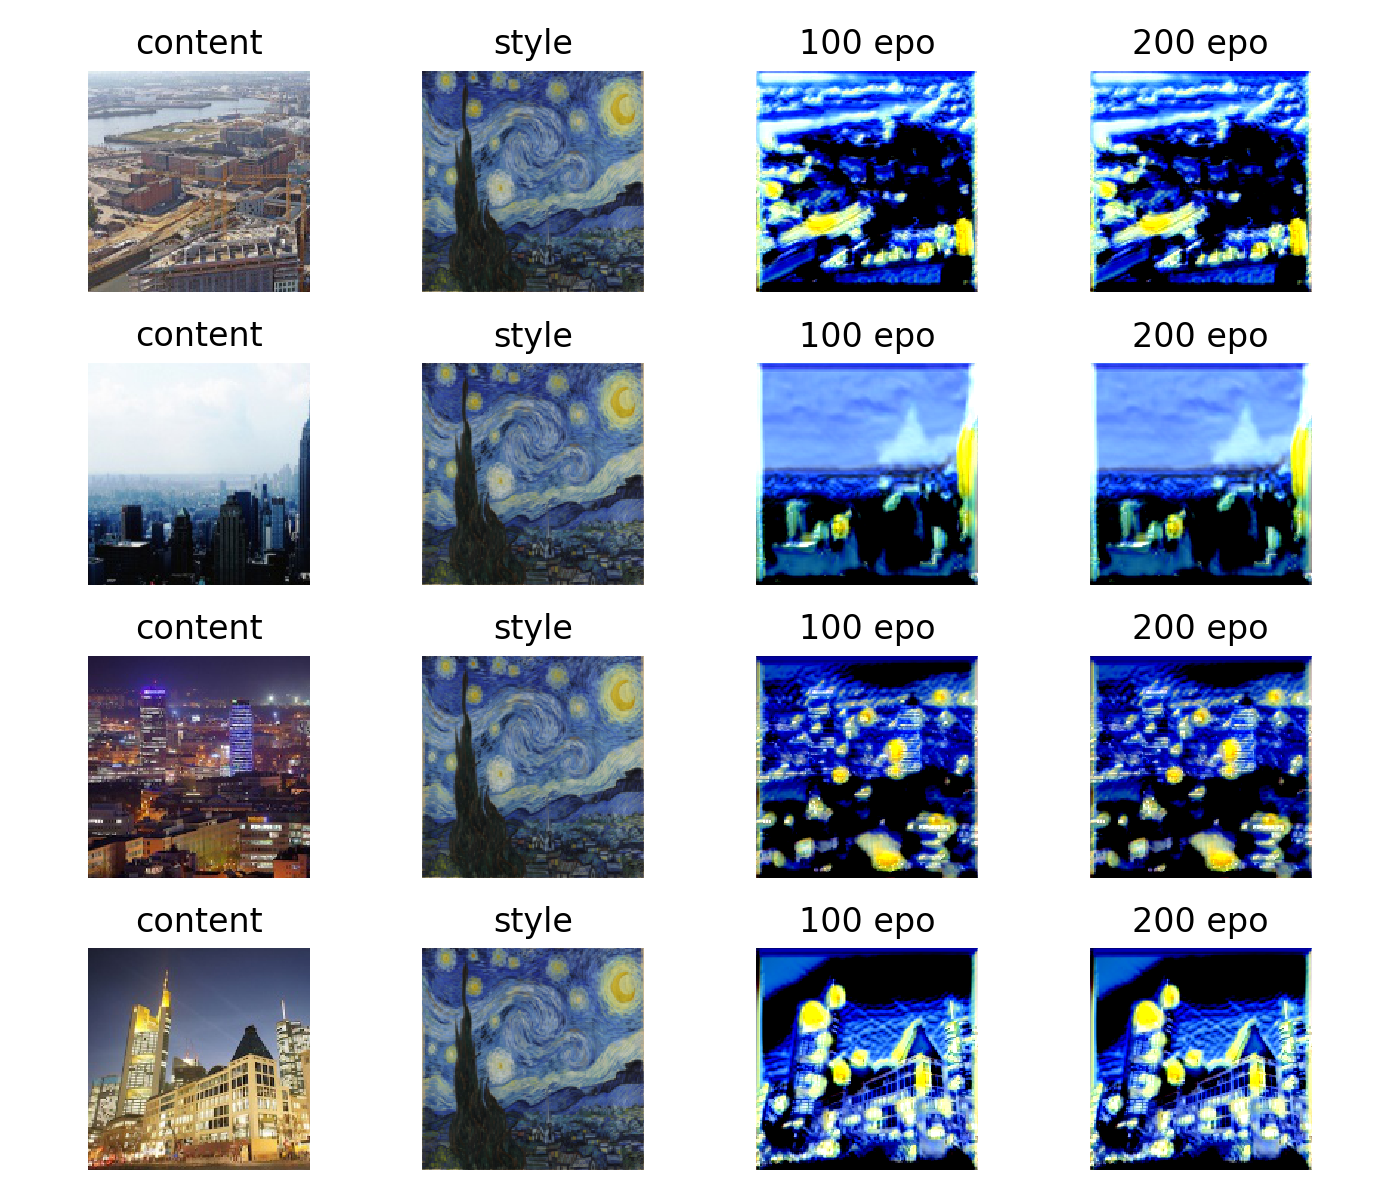

In [12]:
multi_final_result(True, 20, 40, 80, 160)